In [1]:
import tensorflow as tf

In [1]:
import numpy as np
import gym
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make("Pong-v0") # create the pong 'environment'

In [3]:
# show what all the buttons do...
# we're only interested in right/left...this is really up/down
# and no operation (NOOP) - to let the paddle stay where it is
# these are actions 2, 3, 0
env.unwrapped.get_action_meanings() 

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [4]:
raw_pixels = env.reset()
raw_pixels.shape

(210, 160, 3)

In [5]:
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

In [6]:
pixels = prepro(raw_pixels)
pixels.shape

(80, 80)

In [7]:
render = True
slow = True
score = 0
frame_history = []
action_history = []
reward_history = []
done = False # done gets returned from the environment to tell you if this game (first to 21 points) is over
raw_pixels = env.reset()
raw_pixels, reward, done, info = env.step(1)
pixels = prepro(raw_pixels)
while not done:
    action = np.random.choice([0,2,3]) # we'll eventually pick the action from a NN
    if render == True: # do you actually want to visualize the playing?
        env.render()
        if slow == True: # do you want to slow it down so you can see the game better?
            time.sleep(0.005)
    raw_pixels, reward, done, info = env.step(action)
    frame_history.append(pixels)
    action_history.append(action) # these are the action and reward when you saw the last frame
    reward_history.append(reward)
    pixels = prepro(raw_pixels) # now this is the new frame
    score += reward

# after a game, with all that we saved we'll do a little optimization on the NN

In [8]:
score

-21.0

In [9]:
reward_history[-1]

-1.0

In [11]:
len(reward_history)

1283

In [12]:
np.sum(np.array(reward_history)>0)

0

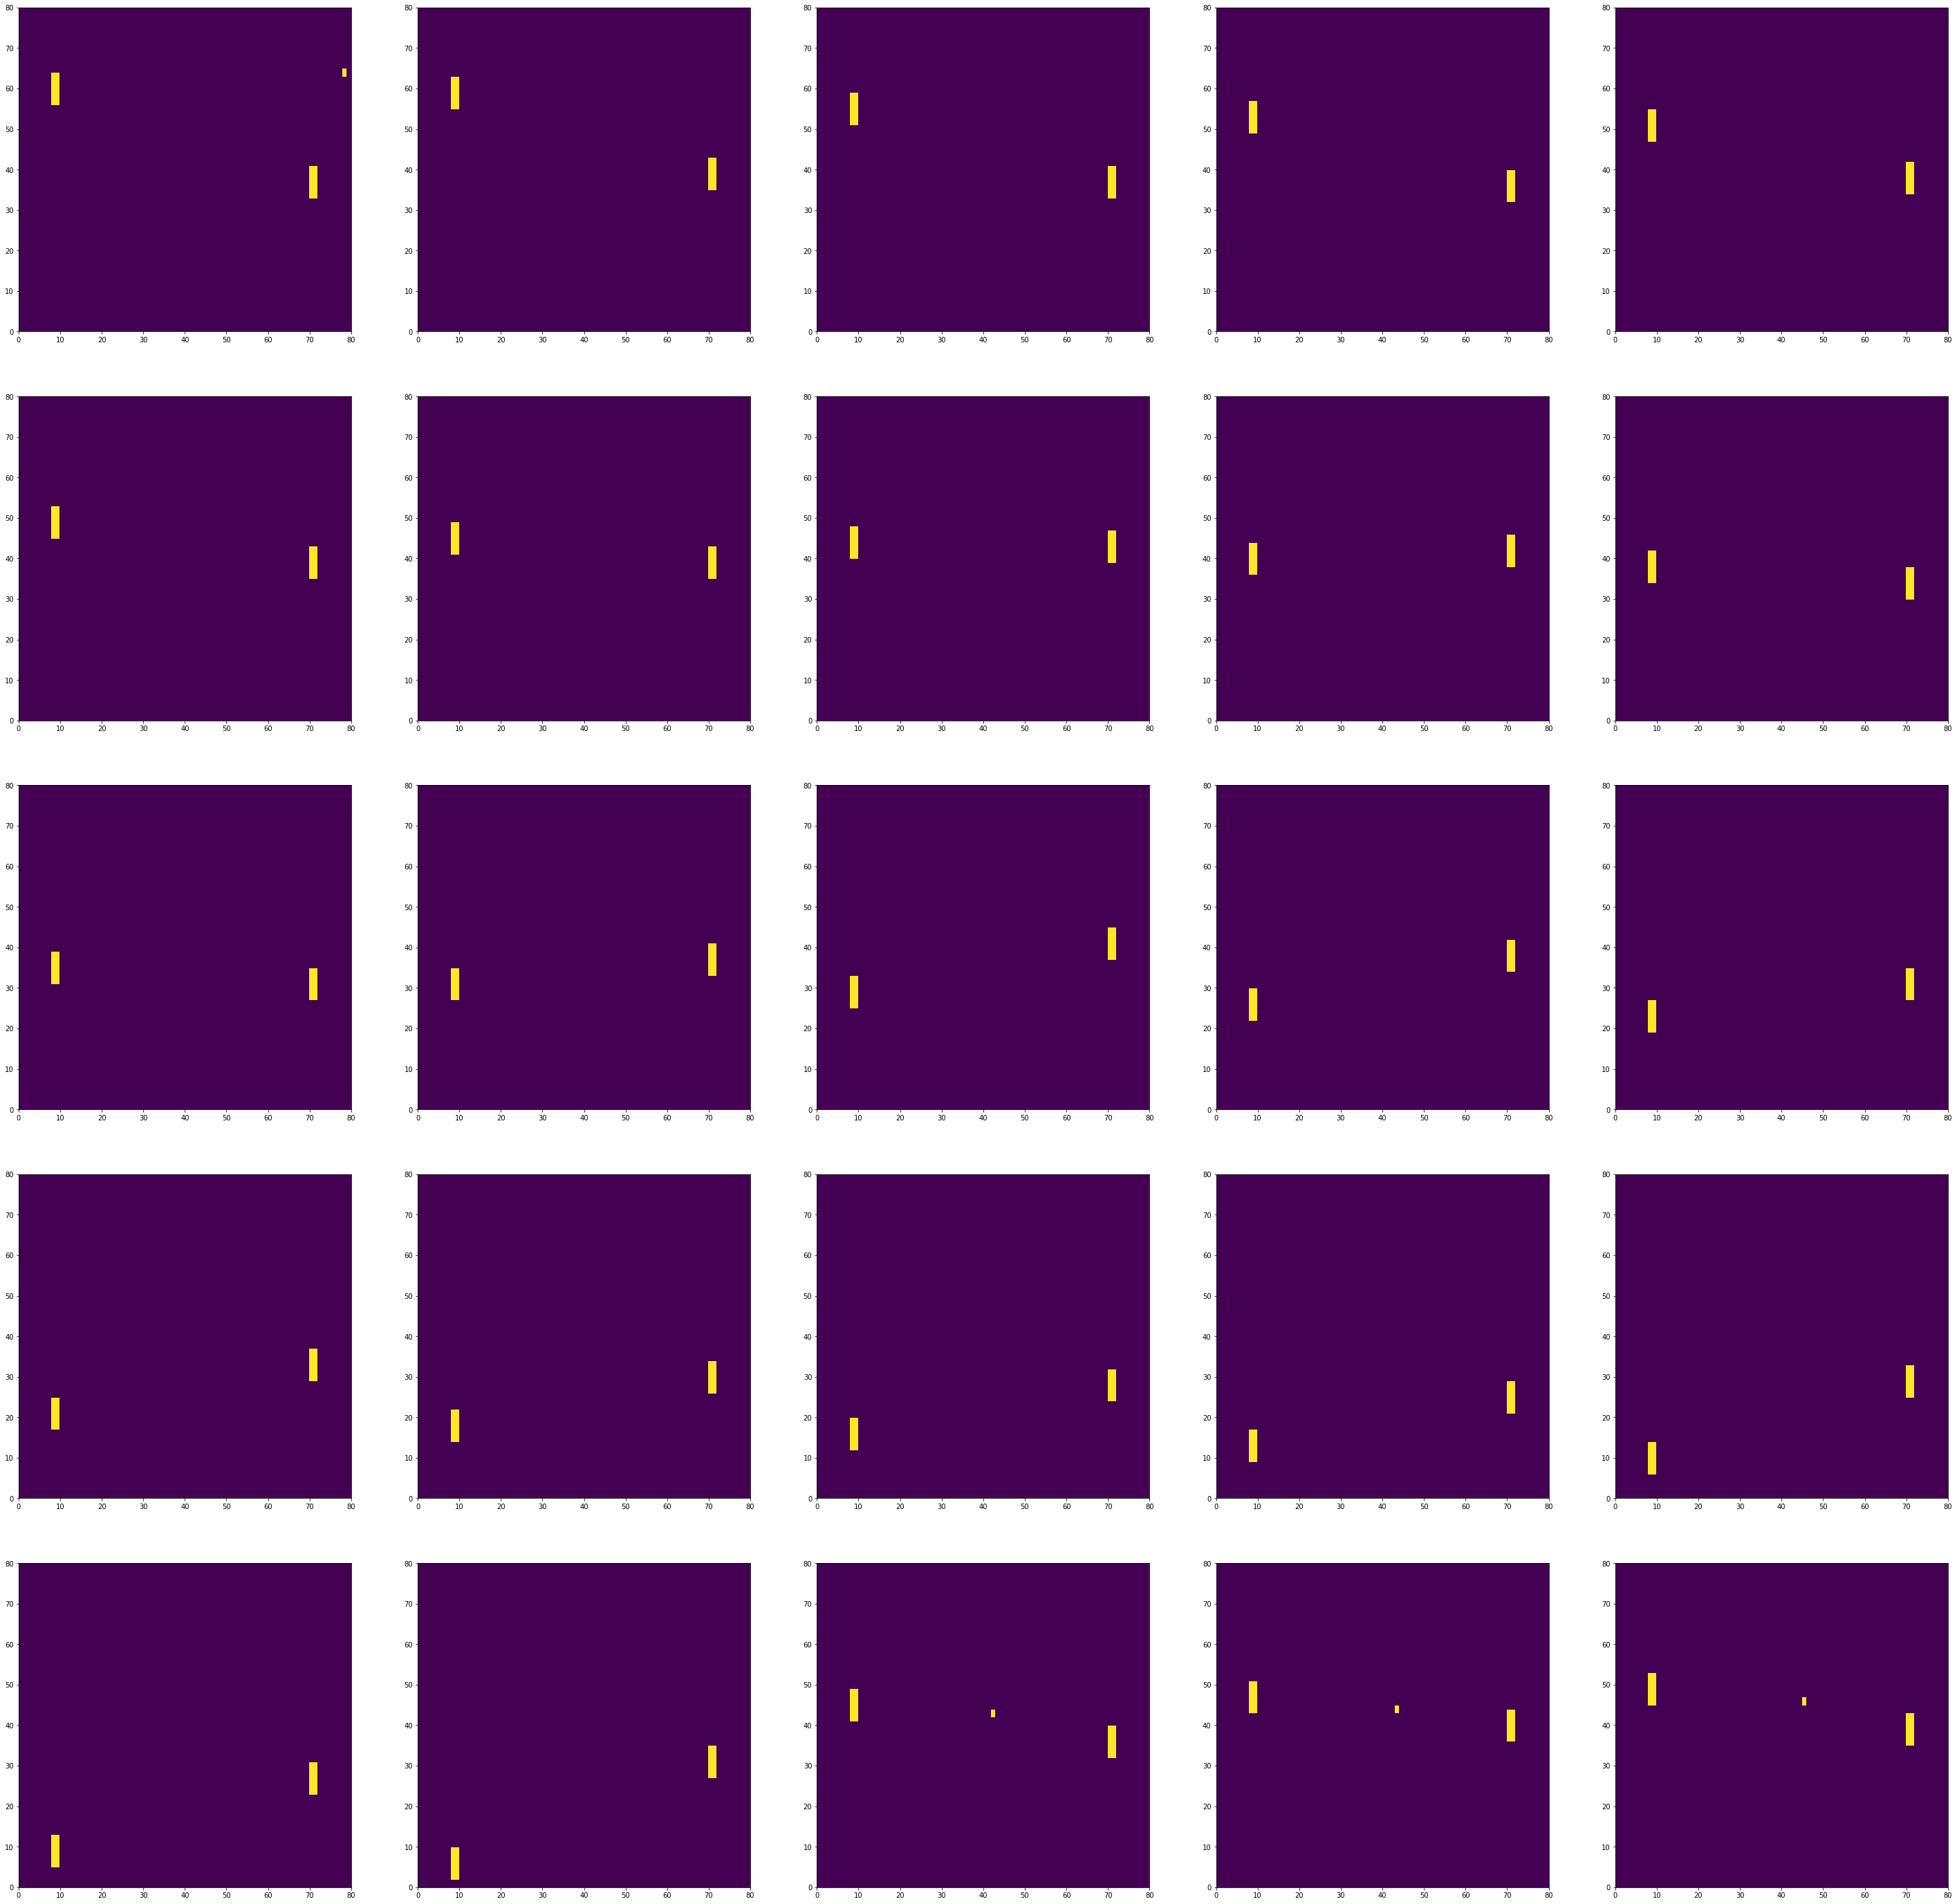

In [13]:
# it takes roughly 20 frames at the beginning of a game, or after a point is scored for play to resume...
# you should probably be careful about this...

nf = 0
done = False
score = 0
raw_pixels = env.reset()
plt.figure(figsize=(50, 50))
why = 1
nextf = 0
while not done:
    nf += 1
    action = np.random.choice([0,2,3]) # we'll eventually pick the action from a NN
    raw_pixels, reward, done, info = env.step(action)
    pixels = prepro(raw_pixels)
    
    score += reward
    
    if reward != 0:
        nextf = 1
    
    if (nextf == 1) & (why<26):
        plt.subplot(5,5,why )
        plt.pcolor(pixels);
        why += 1
        
    

In [ ]:
def run_one_cycle(model,render=False,slow=False,print_freq = False): # run a cycle of playing game a bunch of times
    # intialize the history you need to remember for training
    frame_history = []
    action_history = []
    reward_history = []
    # how often do we take each action?
    num2 = 0
    num3 = 0
    num0 = 0
    # the score for each game in the cycle, so we can track how good we're doing
    scorevec = np.zeros(games_per_cycle)
    # make evaluating the NN faster
    model.call = tf.function(model.call,experimental_relax_shapes=True)
    
    for cycle in range(games_per_cycle): # each iteration of this loop is a game played to 21 points
        
        # we want to consider at least 2 frames when deciding so that we get a sense of speed and direction of the ball
        pixel_obs_new = env.reset() # reset the environment for a new game, output is just the initial pixels
        pixel_obs_new = prepro(pixel_obs_new) # preprocess this image
        pixel_obs_old = np.zeros(pixel_obs_new.shape) # initialize the previous frame as just zeros
        
        # change of pixels from one frame to the next...
        # maybe not the best, maybe should really just store both frames for model to see...tf isn't the bottleneck, playing through gym is...
        pixel_delta = pixel_obs_new-pixel_obs_old 
        score = 0
        done = False # done gets returned from the environment to tell you if this game (first to 21 points) is over
        while not done:

            pixel_feed = np.zeros((1,80,80,1)) # what to give the model
            pixel_feed[0,:,:,0] = pixel_delta # put in the pixel change
            # get probabilities of up/down/still
            probs = model(pixel_feed,training=False).numpy()[0]# model.predict(pixel_feed)...predict is signifincantly slower for some weird reason (overhead...)
            # that is the most time consuming line of the whole code! 
            # training gets WAY faster if you can find a way to parallelize this
            # play games in parallel, or something like that
            # the problem with straight parallelization is that you can't easily put a TF object on multiple cores
            
            # we want to flip a coin that lands heads based on probability of up
            # if it's heads play up, if it's tails play down
            # this is based on the exploration vs exploitation paradigm 
            # we don't want to just play what we think might be best bc we're probably wrong a lot of times
            # allowing for random exploration helps learning
            action0 = np.random.choice([0,2,3],p=probs)

            if action0 == 2: 
                num2 += 1
                # 2 is up, 3 is down (I think...it might be switched but it doesn't matter as long as we're internally consistent)
            elif action0 == 3:
                num3 += 1
            else:
                num0 += 1
            
            
            if render == True: # do you actually want to visualize the playing?
                env.render()
                if slow == True: # do you want to slow it down so you can see the game better?
                    time.sleep(0.01)
            
            pixel_obs_old = pixel_obs_new # shift new to old
            pixel_obs_new, reward, done, info = env.step(action0) # play the action and return what happens next
            frame_history.append(pixel_delta) # store the frames that lead to that action
            pixel_obs_new = prepro(pixel_obs_new) # process the new image
            # since we're using sparse_categorical_crossentropy the output layer's values MUST be 0 and 1 and 2
            if action0 == 0: 
                action = 0 # let action 0 (nothing) be remembered as 0
            elif action0 == 2: # let action 2 (up) be remembered as 1
                action = 1
            else: # let action 3 (down) be rememebered as 2
                action = 2
            action_history.append(action) # remember the action and what our reward was
            reward_history.append(reward)
            
            pixel_delta = pixel_obs_new-pixel_obs_old # calculate the new pixel change
            score += reward # keep track of our score
            

        scorevec[cycle] = score # remember this game's score
    # process everything we stored into appropraite np arrays
    nframes = len(reward_history)
    action_history = np.array(action_history[1:]) # don't learn from the 0th frame...it was basically random
    reward_history = np.array(reward_history[1:])
    
    # rearrange frames
    frame_array = np.zeros((nframes-1,80,80,1))
    for f in range(nframes-1):
        frame_array[f,:,:,0] = frame_history[f+1]
    if print_freq == True:
        print(num0/(num0+num2+num3), num2/(num0+num2+num3), num3/(num0+num2+num3))
    return frame_array, action_history, reward_history, np.mean(scorevec)

In [1]:
import tensorflow as tf

In [ ]:
# let's load a model I spent 2-3 days training
mod2 = tf.keras.models.load_model('pong_model_best3actions.tf')

In [ ]:
# let's see how that model does
games_per_cycle = 1
frames, actions, rewards, meanscore = run_one_cycle(mod2,render=True,slow=True)

In [ ]:
pixels[:,10]= 3
pixels[:,70]= 3
plt.pcolor(pixels);